In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from tqdm import tqdm
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
import pandas as pd
import pandas_market_calendars as mcal
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest
from sklearn.preprocessing import StandardScaler
from analysis import *
from preprocessing import *
from metrics import *
from base import *
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2024-04-23 11:19:24.120230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 11:19:24.120280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 11:19:24.120299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-23 11:19:24.125074: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Stylized facts in synthetic returns**

In [2]:
path = './trained/SPX_Apr08-09-57SPX_e1r1s42/'

trading_calendar = 'NYSE'
gen_start_date = '1995-02-01' # includes the historical path used to condition the generator
gen_end_date = '2022-10-19'
random_dates = True # if True, the generated sequences can start from any randomly sampled date between (1995-01-01 + max(p,o,q) trading days) and (2022-10-19 - (hist_len + n_periods) trading days)
sample_len = 300 # used only if random_dates is True else it is based on gen_start_date and gen_end_date
gen_batch_size = 4 if random_dates else 160

random_seed = False
seed = np.random.randint(0, 100000) if random_seed else 96470

# Generating synthetic returns

In [3]:
if os.uname().sysname == 'Darwin':
    wgt_filename = 'generator/model.keras'
elif os.uname().sysname == 'Linux' and os.uname().nodename.startswith('Desktop'):
    wgt_filename = 'generator/'
events_path = path + 'log/'
params = get_hparams(events_path)
# params['data_params']['sample_len'] = sample_len
params

{'training_params': {'n_iters': 200,
  'batch_size': 32,
  'sinkhorn_eps': 1.0,
  'sinkhorn_l': 200,
  'reg_penalty': 1.0,
  'gen_lr': 0.001,
  'disc_lr': 0.001,
  'patience': 20,
  'factor': 0.5},
 'model_params': {'gen_type': 'lstmd',
  'activation': 'tanh',
  'g_state_size': 64,
  'd_state_size': 64,
  'log_series': True},
 'data_params': {'dname': 'SPX',
  'dt': 0.003968253968253968,
  'sample_len': 300,
  'hist_len': 50,
  'time_steps': 250,
  'stride': 50,
  'seed': 42,
  'Dx': 2}}

In [4]:
# data_params['stride'] = 1
df_spx = pd.read_csv('./data/spx_20231229.csv', index_col=0, parse_dates=True)
df_spx = df_spx.loc['1995-01-01':'2022-10-19']
df_spx['log_returns'] = np.log(df_spx['spx']).diff()
spx_log_returns = np.log(df_spx.loc['1995-04-13':,'spx']).diff().dropna().values # 1995-04-13 is the first date after hist_len ends

In [5]:
seed = 42
rng = np.random.default_rng(seed)
dataset_size = 10000
rng_idx = rng.integers(0, 114, size=dataset_size)
rng_idx

array([10, 88, 74, ..., 40, 64, 70])

In [6]:
generator = get_generator({**params['model_params'], **params['data_params']}, path+wgt_filename)
df = pd.read_csv('./data/spx_20231229.csv', index_col=0, parse_dates=True)
df = df.loc['1995-01-01':, :]
path_generator = GARCH_path_generator(generator, df, '1995-01-01', '2022-10-19', 20, 0, 0, 'Zero', 'GARCH', 'gaussian', 0, random_state=rng)

# create pytorch dataloader from numpy array
calendar = mcal.get_calendar(trading_calendar)
schedule = calendar.schedule(start_date=gen_start_date, end_date=gen_end_date)
list_log_returns = []
gen_dates = path_generator.df_gen.index[path_generator.max_lag+1:].to_series() # must leave sufficient data for GARCH(p,q) to generate noise
sch_dates = schedule.index.to_series()
for start_date_idx in tqdm(rng_idx):
    # start date is randomly chosen from the first n of the dates where n = len(gen_dates) - hist_len - n_periods
    # end date is chosen so that there are a total of hist_len + n_periods dates
    segment_start_date = gen_dates[start_date_idx].date().isoformat() # 'yyyy-mm-dd'
    segment_end_date = sch_dates[start_date_idx + sample_len].date().isoformat()
    output = path_generator.generate(segment_start_date, segment_end_date, trading_calendar, hist_len=50, batch_size=1, n_batches=1)
    path_whist, path_wohist, batch_log_returns, timeline_whist, timeline_wohist = output
    list_log_returns.append(batch_log_returns)
log_returns = np.concatenate(list_log_returns, axis=0)

2024-04-23 11:19:38.532235: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Optimization terminated successfully    (Exit mode 0)
            Current function value: 5855.988337133396
            Iterations: 36
            Function evaluations: 836
            Gradient evaluations: 36
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5855.99
Distribution:                  Normal   AIC:                           11754.0
Method:            Maximum Likelihood   BIC:                           11897.9
                                        No. Observations:                 6999
Date:                Tue, Apr 23 2024   Df Residuals:                     6999
Time:                        11:19:39   Df Model:                            0
                               Volatility Model                              
 

100%|██████████| 10000/10000 [1:31:17<00:00,  1.83it/s]


In [10]:
# CHECK ALIGNMENT OF DATES AND NOISE WITH MMD GENERATOR

# hist_len = 50
# generator = get_generator({**params['model_params'], **params['data_params']}, path+wgt_filename)
# df = pd.read_csv('./data/spx_20231229.csv', index_col=0, parse_dates=True)
# df = df.loc['1995-01-01':, :]
# # rng = np.random.default_rng(seed)
# path_generator = GARCH_path_generator(generator, df, '1995-01-01', '2022-10-19', 20, 0, 0, 'Zero', 'GARCH', 'gaussian', 0, random_state=rng)

# # create pytorch dataloader from numpy array
# calendar = mcal.get_calendar(trading_calendar)
# schedule = calendar.schedule(start_date=gen_start_date, end_date=gen_end_date)
# gen_dates = path_generator.df_gen.index[path_generator.max_lag+1:].to_series() # must leave sufficient data for GARCH(p,q) to generate noise
# sch_dates = schedule.index.to_series()
# noises = []
# start_dates = []
# end_dates = []
# for start_date_idx in tqdm(rng_idx[:10]):
#     # start date is randomly chosen from the first n of the dates where n = len(gen_dates) - hist_len - n_periods
#     # end date is chosen so that there are a total of hist_len + n_periods dates
#     segment_start_date = gen_dates[start_date_idx].date().isoformat() # 'yyyy-mm-dd'
#     segment_end_date = sch_dates[start_date_idx + sample_len].date().isoformat()
#     noise, start_date, end_date = path_generator.generate_noise(segment_start_date, segment_end_date, trading_calendar, hist_len, batch_size=1, n_batches=1)
#     noises.append(noise)
#     start_dates.append(start_date)
#     end_dates.append(end_date)
# noises = np.concatenate(noises, axis=0)
# for i in range(10):
#     print(start_dates[i], end_dates[i])
#     print(noises[i])

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5855.988337133396
            Iterations: 36
            Function evaluations: 836
            Gradient evaluations: 36
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5855.99
Distribution:                  Normal   AIC:                           11754.0
Method:            Maximum Likelihood   BIC:                           11897.9
                                        No. Observations:                 6999
Date:                Tue, Apr 23 2024   Df Residuals:                     6999
Time:                        11:17:42   Df Model:                            0
                               Volatility Model                              
 

100%|██████████| 10/10 [00:00<00:00, 54.48it/s]

1995-02-16 1996-04-24
[[-0.4852995  -0.76875854  0.28060508  0.05156279]
 [-0.17779712 -0.22534403  0.28727075  0.0549057 ]
 [ 0.09552315 -0.26176617 -0.32885736  0.42167988]
 ...
 [-0.11278339  0.11284091  0.9567988   0.4381467 ]
 [ 1.5475751  -0.46560118  1.9294007   0.15425324]
 [ 0.8355505  -0.4104676   0.2537355   0.04196322]]
1995-06-09 1996-08-14
[[-1.1148442  -0.28408498 -0.7078653  -0.5025022 ]
 [ 1.0222874   0.06808228  0.96302307 -0.1380888 ]
 [-0.57207215 -0.9615673  -0.37772447  0.80184066]
 ...
 [ 2.4050992  -0.09126661  0.8023278   0.826691  ]
 [-0.36133593  0.30840525  0.19031584  0.20108795]
 [ 0.14132309 -0.71828043  1.1477941   0.25680494]]
1995-05-19 1996-07-25
[[ 0.27323213 -1.0567153  -0.02418707 -0.5536806 ]
 [-0.5185671   0.24452488  0.3751121  -0.14856026]
 [ 0.19885278 -0.28945914 -0.08233327 -0.30820966]
 ...
 [ 0.12160353 -0.09010268  0.44799718  0.28094527]
 [ 0.46846122 -0.43583897 -0.01627809  0.23205309]
 [ 0.20367958  0.41327482 -0.57075983 -0.30660403]

In [7]:
torch.save(log_returns, 'log_returns.pt')

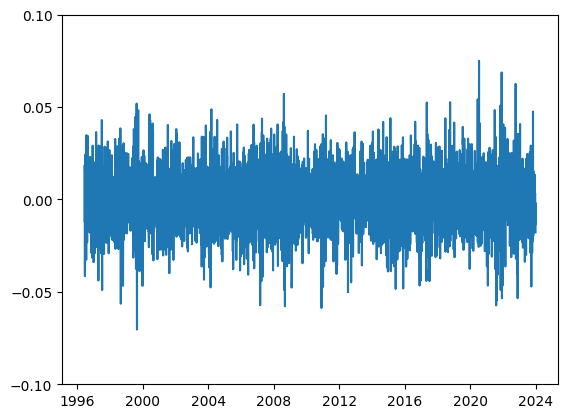

In [6]:
i = 43
ax = plt.subplot()
ax.plot(df.index[-len(log_returns[i]):], log_returns[i].numpy());
# ax.set_ylim(-0.1, 0.1);
ax.set_yticks(np.arange(-0.1, 0.11, 0.05));

# Compare real vs. synthetic distributions

In [7]:
idx = 43

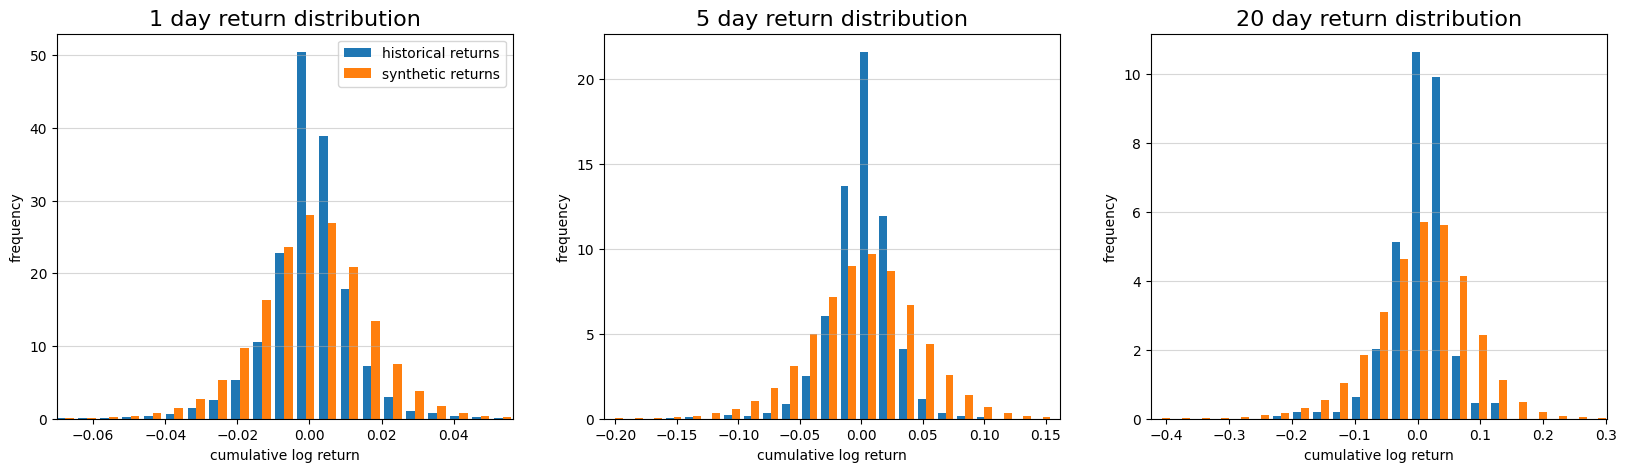

In [8]:
n_bins = 100
windows = [1, 5, 20]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

for i in range(len(windows)):
    real_dist = sliding_window_view(spx_log_returns, windows[i])
    real_dist = real_dist[::windows[i]]
    real_dist = real_dist.sum(axis=-1)
    fake_dist = sliding_window_view(log_returns, windows[i], axis=1)
    fake_dist = fake_dist[:,::windows[i],:]
    fake_dist = fake_dist.sum(axis=-1)

    ax[i].hist(np.array([real_dist, fake_dist], dtype='object'), bins=n_bins, density=True)
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    ax[i].set_title('{} day return distribution'.format(windows[i]), size=16)
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['historical returns', 'synthetic returns'])

In [9]:
windows = pd.Series([1, 5, 20], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(spx_log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(log_returns.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    # fake_dist = rolling_window(log_returns[idx], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
df_EMD

,Earth Mover Distance
window size,
1,0.003977
5,0.017759
20,0.026409


## Aggregational Gaussianity

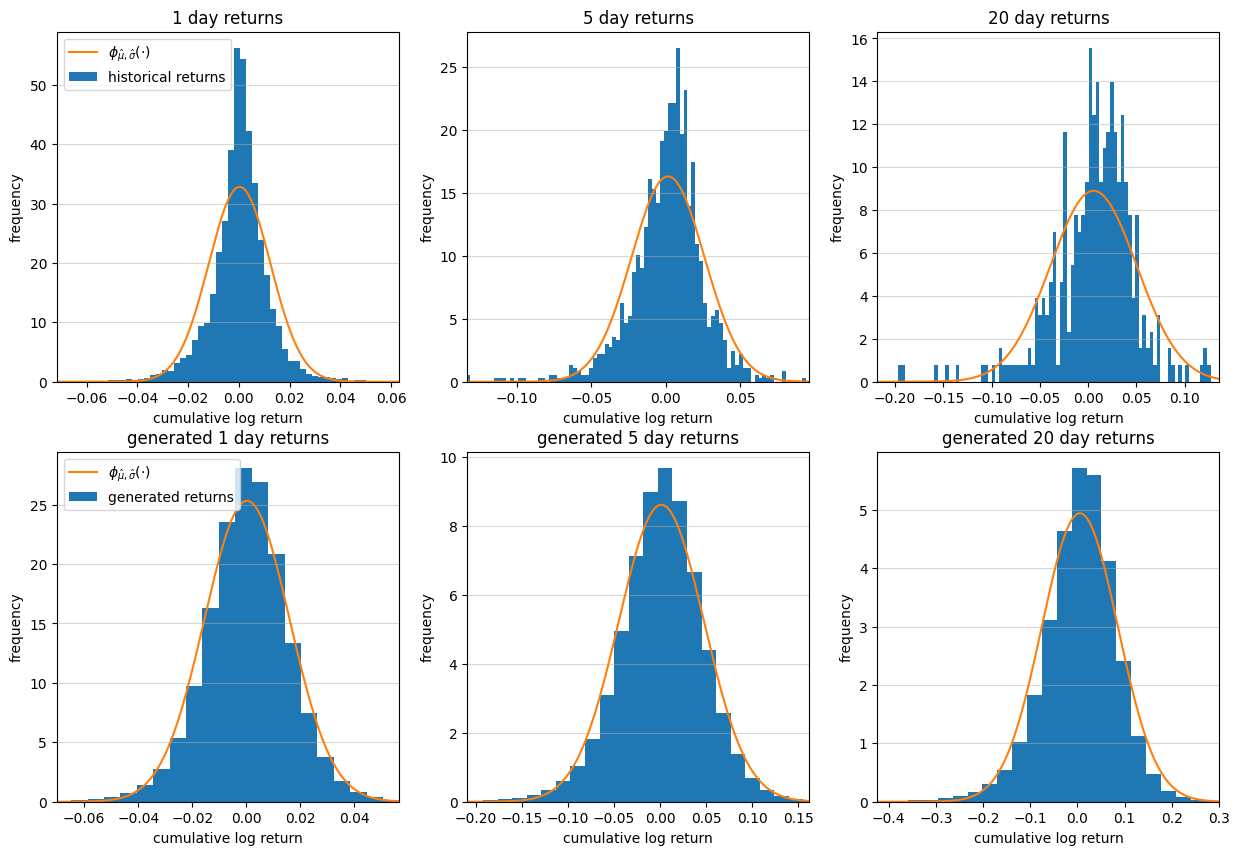

In [10]:
windows = [1, 5, 20]
n_bins = 100

fig, ax = plt.subplots(nrows=2, ncols=len(windows), figsize=(5*len(windows),10))

for i in range(len(windows)):
    if windows[i] == 1:
        real_dist = spx_log_returns
        fake_dist = log_returns
    else:
        real_dist = sliding_window_view(spx_log_returns, windows[i])
        real_dist = real_dist[::windows[i],:]
        real_dist = real_dist.sum(axis=-1)
        fake_dist = sliding_window_view(log_returns, windows[i], axis=1)
        fake_dist = fake_dist[:,::windows[i],:]
        fake_dist = fake_dist.sum(axis=-1)

    ax[0,i].hist(real_dist.ravel(), bins=n_bins, density=True)
    x_range = np.linspace(*ax[0,i].get_xlim(), 10000)
    ax[0,i].plot(x_range, norm.pdf(x_range, real_dist.mean(), real_dist.std()))
    ax[0,i].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    ax[0,i].set_title('{} day returns'.format(windows[i]))
    ax[0,i].yaxis.grid(True, alpha=0.5)
    ax[0,i].set_xlabel('cumulative log return')
    ax[0,i].set_ylabel('frequency')

    ax[1,i].hist(fake_dist.ravel(), bins=n_bins, density=True)
    x_range = np.linspace(*ax[1,i].get_xlim(), 10000)
    ax[1,i].plot(x_range, norm.pdf(x_range, fake_dist.mean(), fake_dist.std()))
    ax[1,i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    ax[1,i].set_title('generated {} day returns'.format(windows[i]))
    ax[1,i].yaxis.grid(True, alpha=0.5)
    ax[1,i].set_xlabel('cumulative log return')
    ax[1,i].set_ylabel('frequency')

ax[0,0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'historical returns'], loc='upper left');
ax[1,0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'generated returns'], loc='upper left');

In [11]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 6))

for i in range(len(windows)):
    real_dist = rolling_window(spx_log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).squeeze()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue
    stats_array[i, 4] = np.mean(real_dist)
    stats_array[i, 5] = np.std(real_dist) * np.sqrt(252 / windows[i])

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value', 'mean', 'std'], index=windows)

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value,mean,std
window size,,,,,,
1,-0.415,0.0,10.069,0.0,0.000,0.193
5,-0.847,0.0,6.499,0.0,0.001,0.177
20,-1.346,0.0,6.621,0.0,0.006,0.168
100,-1.286,0.0,3.800,0.0,0.029,0.160


In [12]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 6))

for i in range(len(windows)):
    fake_di = rolling_window(log_returns.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    # fake_di = rolling_window(log_returns[idx], windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    stats_array[i, 0] = skew(fake_di)
    stats_array[i, 1] = skewtest(fake_di).pvalue
    stats_array[i, 2] = kurtosis(fake_di)
    stats_array[i, 3] = kurtosistest(fake_di).pvalue
    stats_array[i, 4] = np.mean(fake_di)
    stats_array[i, 5] = np.std(fake_di) * np.sqrt(252 / windows[i])

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value', 'mean', 'std'], index=windows)

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value,mean,std
window size,,,,,,
1,-0.320,0.0,2.548,0.0,0.000,0.250
5,-0.415,0.0,3.125,0.0,0.001,0.329
20,-1.000,0.0,10.997,0.0,0.005,0.287
100,-1.855,0.0,20.852,0.0,0.026,0.341


In [15]:
mean, std, skew, kurtosis = print_statistics(spx_log_returns)

Mean annualised log return (252): 0.07208914341849929
Std annualised log return (252): 0.1929417544395052
Min log return: -0.12765219747281709 / Max log return: 0.10957196759533883
Skewness: -0.4152298382938198 (0=normal)
Kurtosis: 10.069061632054298 (0=normal under Fisher's definition)
Normal test: NormaltestResult(statistic=1403.363888786031, pvalue=1.8340175997611212e-305)
Skewness test: SkewtestResult(statistic=-13.579229515951, pvalue=5.318293868948914e-42)
Kurtosis test: KurtosistestResult(statistic=34.91372816728624, pvalue=4.602144580593446e-267)


Mean annualised log return (252): 0.06584825366735458
Std annualised log return (252): 0.24976767599582672
Min log return: -0.44113993644714355 / Max log return: 0.16589656472206116
Skewness: -0.28730640939435775 (0=normal)
Kurtosis: 2.0984336859013313 (0=normal under Fisher's definition)
Normal test: NormaltestResult(statistic=527426.659481618, pvalue=0.0)
Skewness test: SkewtestResult(statistic=-335.81890930263256, pvalue=0.0)
Kurtosis test: KurtosistestResult(statistic=643.935027496104, pvalue=0.0)


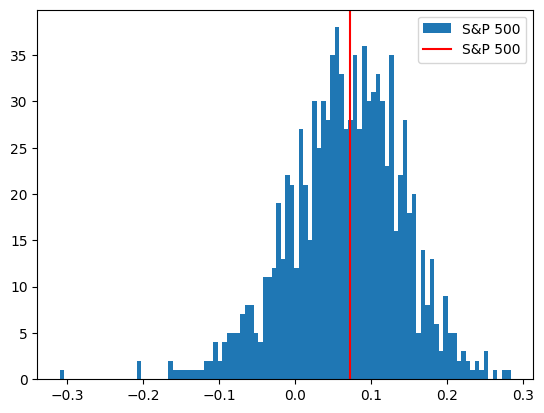

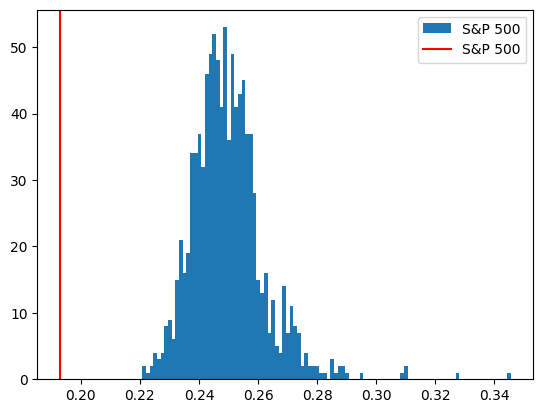

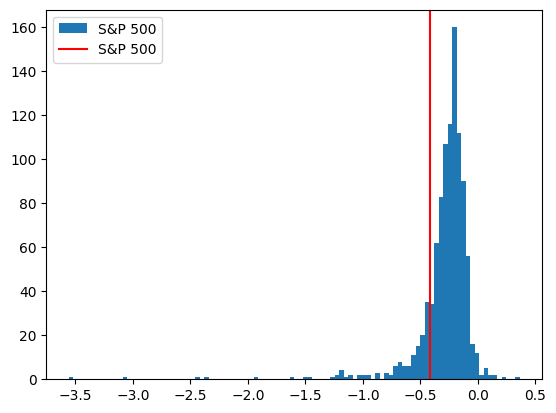

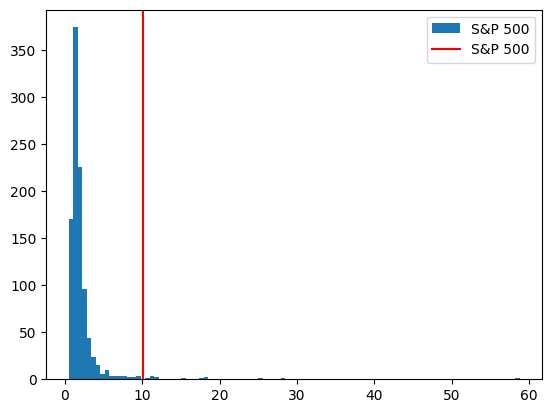

In [16]:
print_statistics(log_returns, mean, std, skew, kurtosis)

# Gain/loss assymetry

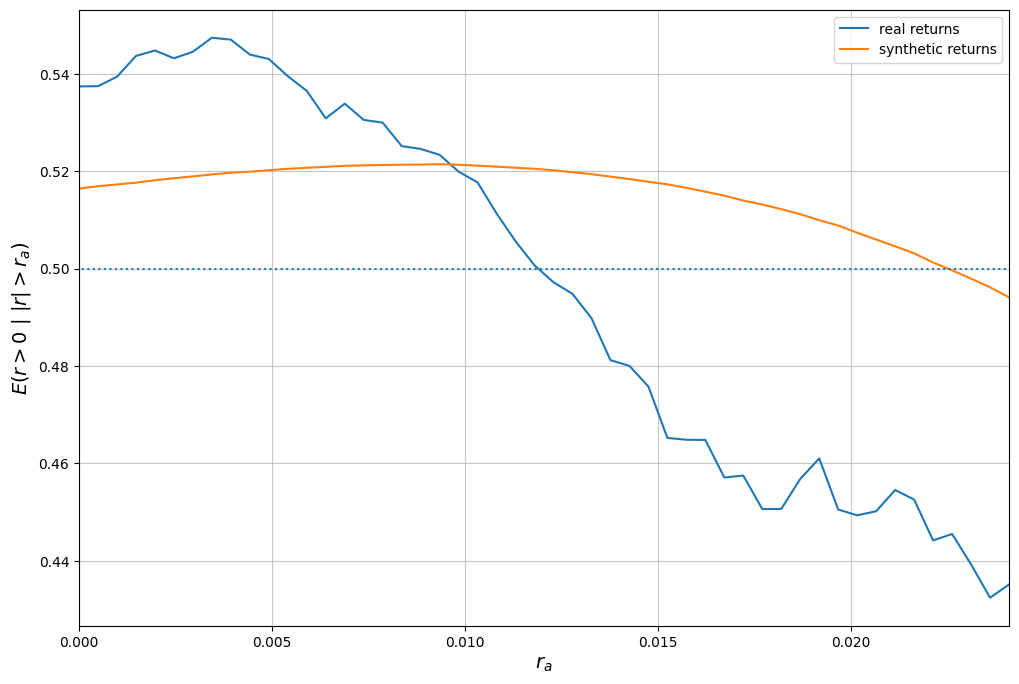

In [17]:
real_dist = spx_log_returns.squeeze()
fake_dist = log_returns.numpy().ravel()
# fake_dist = log_returns[idx].numpy()

loss_assymetry = lambda dist, x: np.mean((dist[np.abs(dist) > x] >= 0))

fig, ax = plt.subplots(figsize=(12,8))
x_range = np.linspace(0, np.quantile(np.abs(real_dist), .95), 50)
ax.plot(x_range, [loss_assymetry(real_dist, x) for x in x_range], label='real returns')
ax.plot(x_range, [loss_assymetry(fake_dist, x) for x in x_range], label='synthetic returns')
ax.hlines(0.5, -1, 1, linestyles='dotted');
ax.set_xlim(0, np.quantile(np.abs(real_dist), .95))

ax.set_xlabel('$r_a$', size=14)
ax.set_ylabel('$E(r > 0$ | $|r| > r_a)$', size=14)

ax.grid(alpha=0.7)

ax.legend();

Text(0, 0.5, 'ECDF')

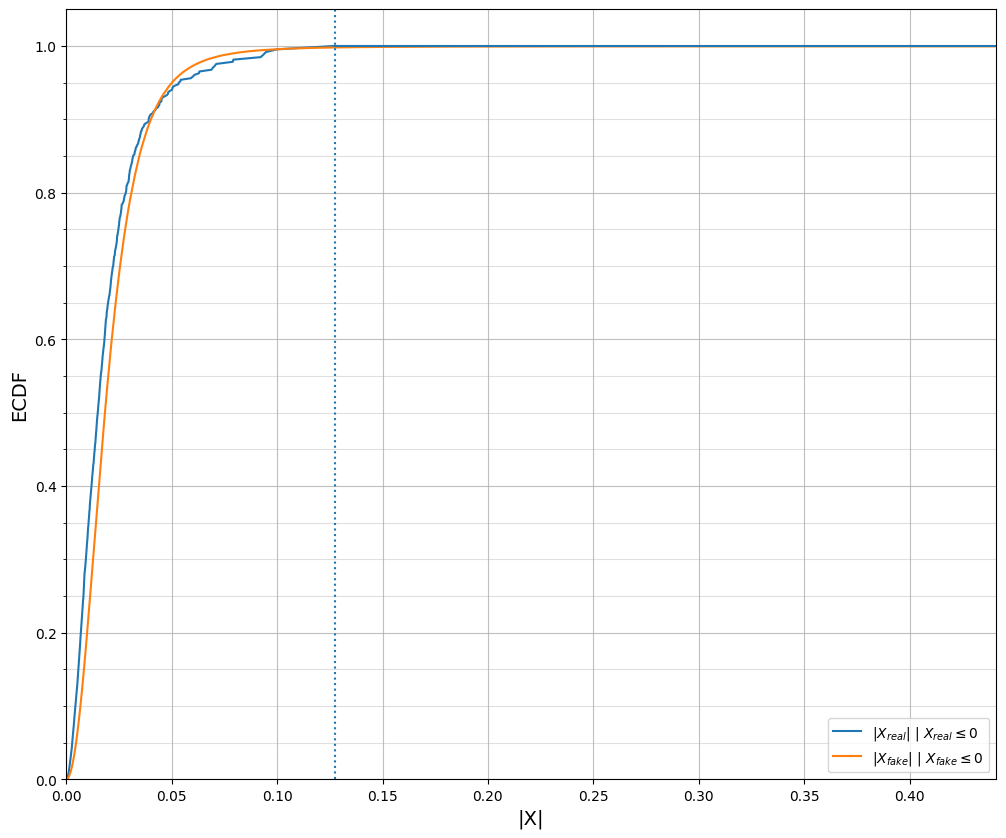

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

x_real = np.sort(abs(real_dist[real_dist <= 0]))
x_fake = np.sort(abs(fake_dist[fake_dist <= 0]))

plt.plot(x_real, x_real.cumsum()/x_real.sum())
plt.plot(x_fake, x_fake.cumsum()/x_fake.sum())

ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.8)

ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, .05), minor=True)

plt.xlim(0, max(x_fake))
plt.ylim(0, 1.05)


plt.plot([max(x_real), max(x_fake)], [1, 1], color='#1f77b4')

ax.vlines(max(x_real), 0, 1.5, linestyles='dotted')

ax.legend(['$|X_{real}|$ | $X_{real} \leq 0$', '$|X_{fake}|$ | $X_{fake} \leq 0$'])

ax.set_xlabel('|X|', size=14)
ax.set_ylabel('ECDF', size=14)

# Intermittency

Text(0, 0.5, '$\\hat{\\sigma}_t$')

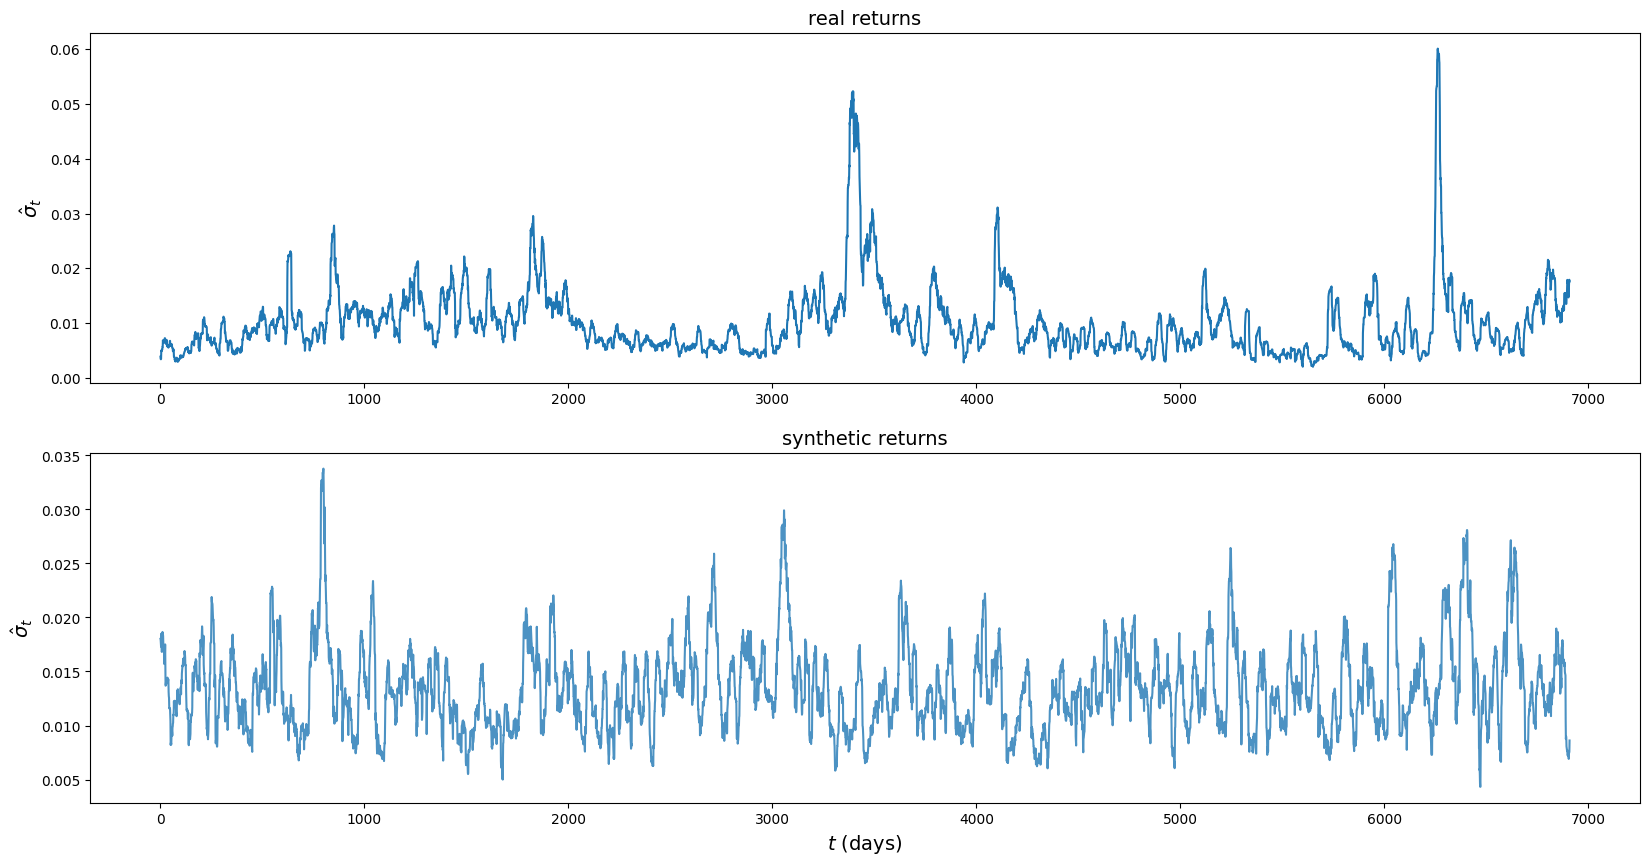

In [19]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
ax[0].plot(rolling_window(spx_log_returns, 20).std(axis=0))
ax[0].set_title('real returns', size=14)
# ax[1].plot(rolling_window(log_returns[:5].T, 20).std(axis=0), alpha=0.8)
ax[1].plot(rolling_window(log_returns[idx], 20).std(axis=0), alpha=0.8)
ax[1].set_title('synthetic returns', size=14)

ax[1].set_xlabel('$t$ (days)', size=14)
ax[0].set_ylabel('$\hat{\sigma}_t$', size=14)
ax[1].set_ylabel('$\hat{\sigma}_t$', size=14)

# Volatility clustering

In [20]:
def mad(x, axis=None):
    return np.mean(np.abs(x - np.mean(x, axis=axis)), axis=axis)

/tmp/ipykernel_18163/2677529976.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  fake_acf = np.array([acf(rolling_window(lr.T, 20).std(axis=0), T) for lr in log_returns])


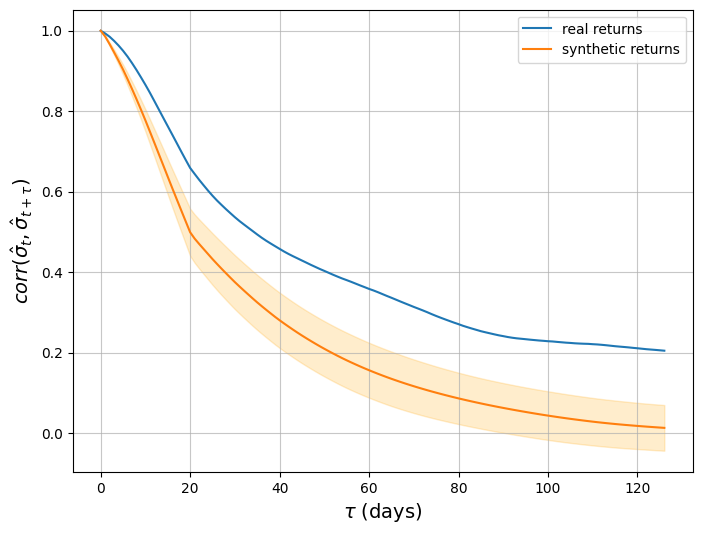

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

T = 127

ax.plot(acf(rolling_window(spx_log_returns, 20).std(axis=0), T));

fake_acf = np.array([acf(rolling_window(lr.T, 20).std(axis=0), T) for lr in log_returns])
ax.plot(fake_acf.mean(axis=0))
ax.fill_between(np.arange(T), fake_acf.mean(axis=0) - mad(fake_acf, axis=0), fake_acf.mean(axis=0) + mad(fake_acf, axis=0), alpha=0.2, color='orange')

# fake_acf = acf(rolling_window(log_returns[idx], 20).std(axis=0), T)
# ax.plot(fake_acf)

ax.grid(alpha=0.7)

ax.set_xlabel('$\\tau$ (days)', size=14)
ax.set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$', size=14)
ax.legend(['real returns', 'synthetic returns'])

# Tail index

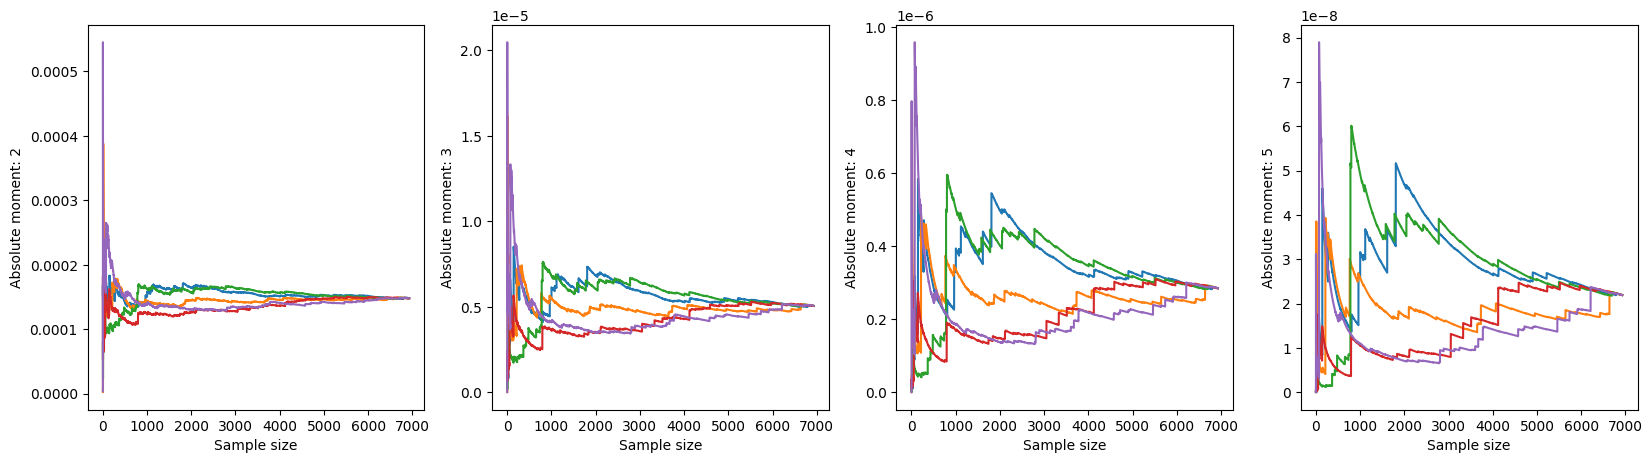

In [22]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(spx_log_returns))
ylims = []

for i in range(5):
    shuffled_array = rng.permutation(spx_log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);
        if i==4: ylims.append(ax[j].get_ylim()[1])

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

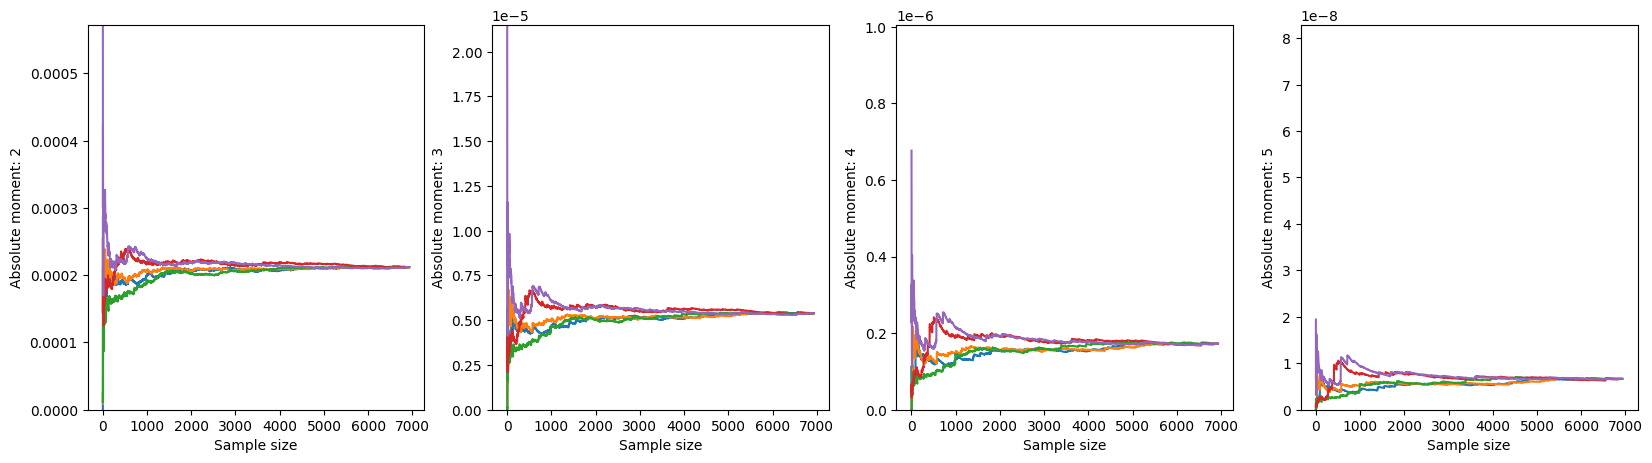

In [23]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(spx_log_returns))

for i in range(5):
    shuffled_array = rng.permutation(log_returns[idx])

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);
        if i==4: ax[j].set_ylim(0, ylims[j])

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

In [24]:
# absolute_moments = [2, 3, 4, 5]

# fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
# x_range = range(1, len(spx_log_returns))

# # shuffle along first index, so tranpose
# shuffled_array = rng.permutation(log_returns.T)

# for j in range(len(absolute_moments)):
#     paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
#     ax[j].plot(x_range, paths, alpha=0.5)
#     ax[j].set_ylim(0, ylims[j-4])
#     # ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
#     ax[j].set_xlabel('Sample size')
#     ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))

# # Note the underflow warning, i.e. some returns when raised to a high power produce
# # values so small that they fall outside of the range of float32,
# # this is not a big deal

# Autocorrelation effects

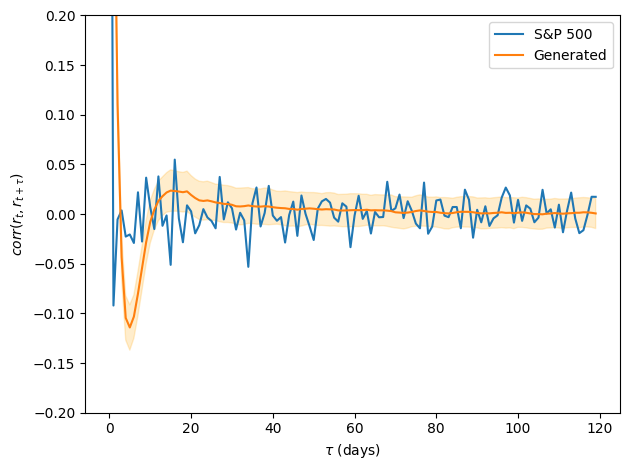

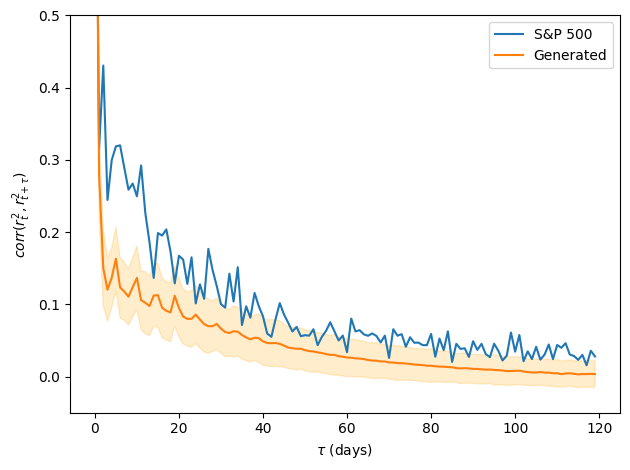

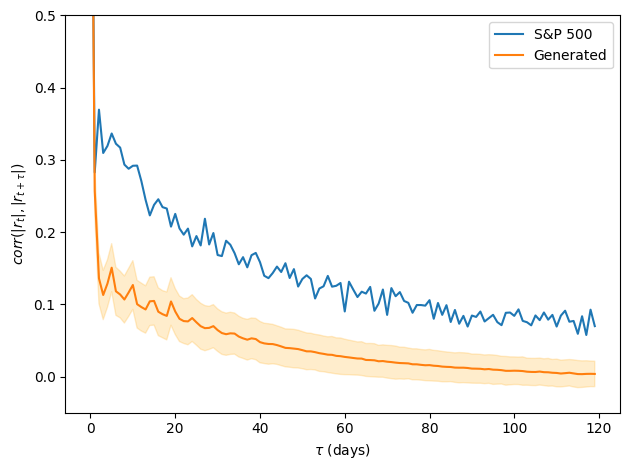

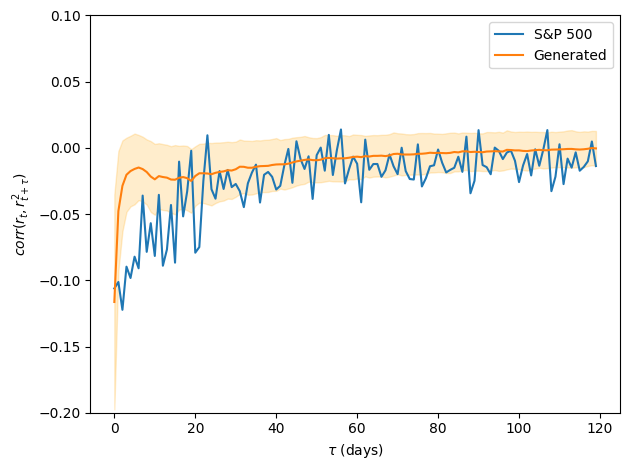

In [25]:
n_days = 120
fig = plt.figure()
ax = plt.subplot()
ax.plot(acf(spx_log_returns, n_days), label='S&P 500')
acf_values = np.array([acf(lr, n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
# acf_diff = mad(acf_values, axis=0)
acf_diff = acf_values.std(axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_diff, acf_values.mean(axis=0) - acf_diff, alpha=0.2, color='orange')
ax.set_ylim(-0.2, 0.2)
ax.set_ylabel('$corr(r_t, r_{t+\\tau})$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
ax.plot(acf(spx_log_returns**2, 120), label='S&P 500')
ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('$corr(r_t^2, r_{t+\\tau}^2)$')
acf_values = np.array([acf(lr**2, n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
# acf_diff = mad(acf_values, axis=0)
acf_diff = acf_values.std(axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_diff, acf_values.mean(axis=0) - acf_diff, alpha=0.2, color='orange')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
ax.plot(acf(abs(spx_log_returns), n_days, le=False), label='S&P 500')
acf_values = np.array([acf(np.abs(lr), n_days) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
# acf_diff = mad(acf_values, axis=0)
acf_diff = acf_values.std(axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_diff, acf_values.mean(axis=0) - acf_diff, alpha=0.2, color='orange')
ax.set_ylim(-0.05, 0.5)
ax.set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

fig = plt.figure()
ax = plt.subplot()
ax.plot(acf(spx_log_returns, n_days, le=True), label='S&P 500')
acf_values = np.array([acf(lr, n_days, le=True) for lr in log_returns])
ax.plot(acf_values.mean(axis=0), label='Generated')
# ax.fill_between(np.arange(n_days), acf_values.min(axis=0), acf_values.max(axis=0), alpha=0.2, color='orange')
# acf_diff = mad(acf_values, axis=0)
acf_diff = acf_values.std(axis=0)
ax.fill_between(np.arange(n_days), acf_values.mean(axis=0) + acf_diff, acf_values.mean(axis=0) - acf_diff, alpha=0.2, color='orange')
ax.set_ylim(-0.2, 0.1)
ax.set_ylabel('$corr(r_t, r_{t+\\tau}^2)$')
plt.setp(ax, xlabel='$\\tau$ (days)')
plt.legend()
plt.tight_layout()

Text(0, 0.5, 'cumulative return (%)')

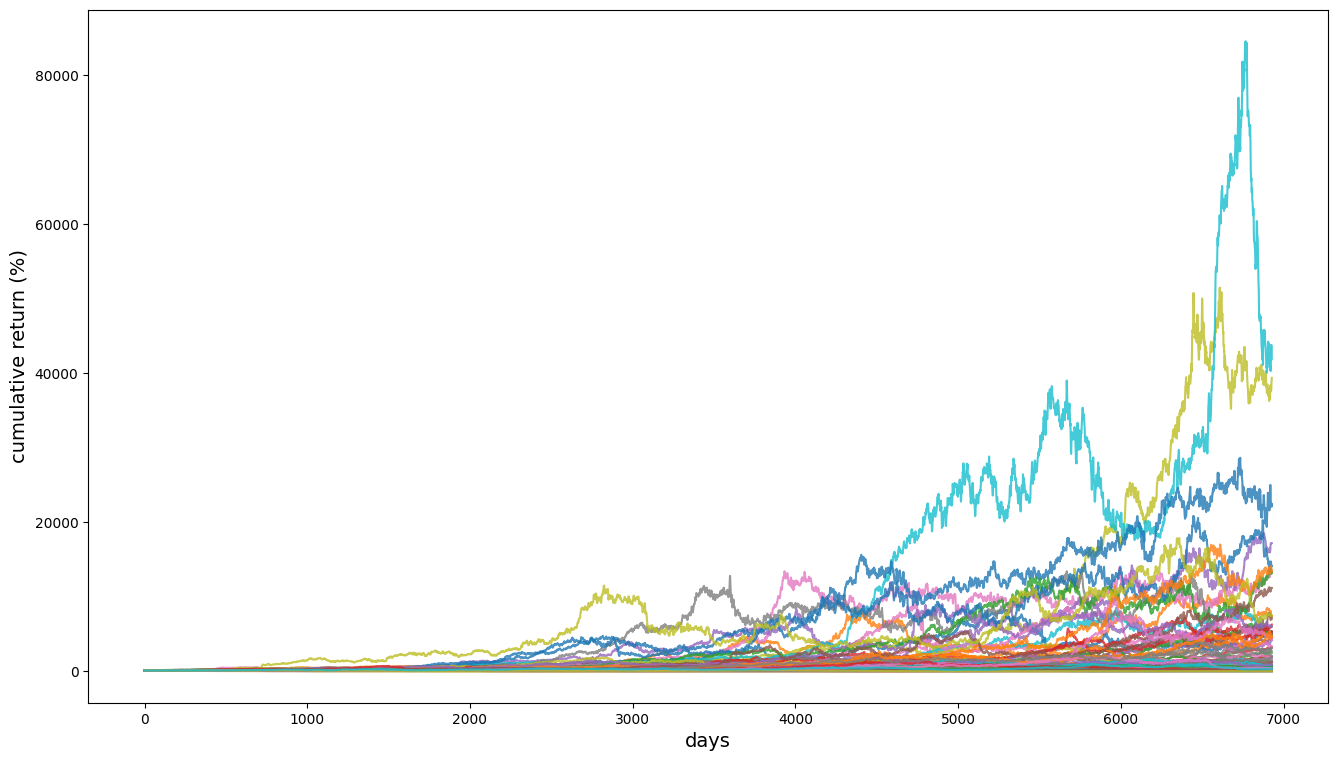

In [26]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(np.exp(log_returns.T[:,:100]).cumprod(axis=0)*100, alpha=0.8)
ax.set_xlabel('days', size=14)
ax.set_ylabel('cumulative return (%)', size=14)

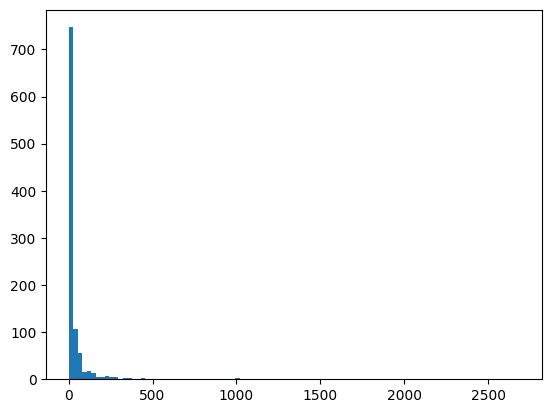

In [37]:
plt.hist(path_whist[:,-1], bins=100);